# Who wants to run a pipeline end-to-end at lightning speed ?

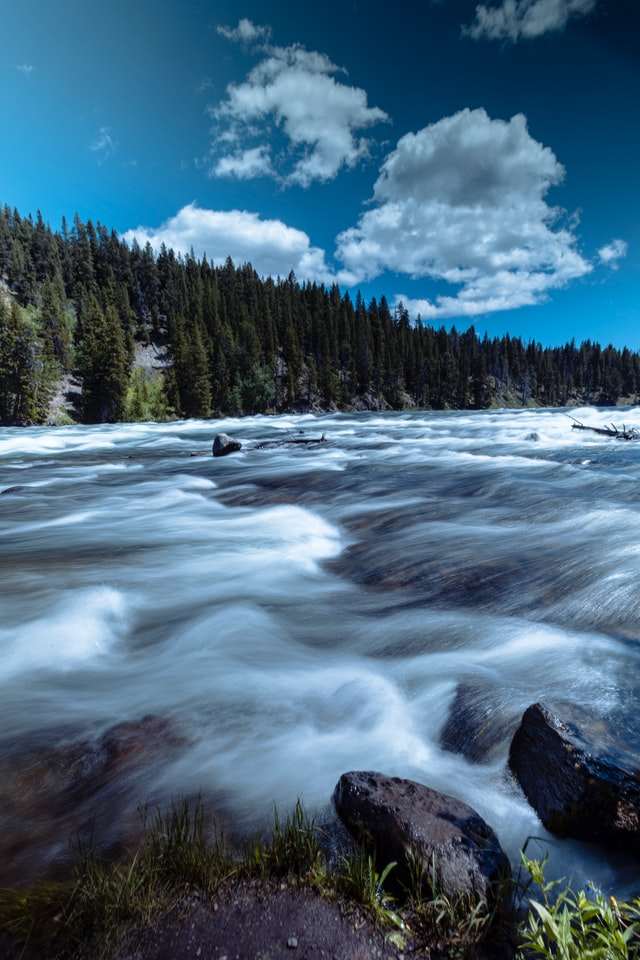
<span> <center>Photo by <a href="https://unsplash.com/@loganmayerr?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Logan Mayer</a> on <a href="https://unsplash.com/s/photos/rapids?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a> </center></span>

## Check my previous notebook on a similar topic : https://www.kaggle.com/louise2001/rapids-feature-importance-is-all-you-need

### It has become so easy now to get amazing NVIDIA GPUs to run your models that you can always try bigger and bigger, achieving amazing performances in no time.

## However, I always find that pre- and post-processing take a huuuuuge amount of the total running time of my pipeline.

### It's not even the hard part ! Nothing like updating millions of weights, very often there are only some basic transformations, filtering and cleaning. What takes long is mostly the copying back and forth between CPU and GPU, and the poor CPU performance compared to GPU even on simple sklearn models.

## Still, it would be a fatal error to neglect those steps... Very often, they create the decisive improvement that can help your model learn loads better and thus lead you towards victory.

# Be fast !

## In this notebook, I will show you how to run your pipeline end-to-end on GPU, thus benefiting from its amazing calculation performances while simplifying the procedure by running everything on a single device.

## First step : setup your RAPIDS environment. 

### RAPIDS are a suite of packages that enable you to run all your favorite procedures, based on pandas, sklearn etc, entirely on GPU.

In [ ]:
%%time
# Import the Rapids suite here - takes abot 2 mins

import sys
!cp ../input/rapids/rapids.0.17.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [ ]:
import os
import gc
import sys
import random
from tqdm.notebook import * 
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd,numpy as np


import cudf
from cuml.linear_model import LogisticRegression
from cuml.svm import SVC, SVR
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors

from cuml.metrics import roc_auc_score
from cuml.preprocessing import LabelEncoder
from cuml.experimental.preprocessing import MinMaxScaler
from cuml.linear_model import MBSGDClassifier as cumlMBSGDClassifier
from cuml.naive_bayes import MultinomialNB


from sklearn.model_selection import StratifiedKFold

import warnings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
warnings.simplefilter("ignore")
warnings.filterwarnings('ignore')

### Hereunder I define the parameters I will be using throughout this notebook.

In [ ]:
DATA_PATH = "../input/widsdatathon2021/"

NA = -9999999999

TARGET = 'diabetes_mellitus'
KEY = 'encounter_id'
useless = ['patient_id', 'hospital_id', 'Train','readmission_status','d1_resprate_max',
'paco2_apache',
'paco2_for_ph_apache',
'ventilated_apache',
'd1_hco3_max',
'h1_temp_max',
'h1_sysbp_invasive_min',
'resprate_apache',
'h1_mbp_noninvasive_max',
'd1_arterial_pco2_max',
'd1_sysbp_invasive_min',
'apache_post_operative',
'h1_resprate_max',
'h1_heartrate_max',
'h1_heartrate_min',
'd1_arterial_pco2_min',
'd1_lactate_max',
'elective_surgery',
'cirrhosis',
'solid_tumor_with_metastasis',
'icu_stay_type',
'gcs_unable_apache',
'h1_arterial_pco2_min',
'hepatic_failure',
'h1_lactate_max',
'immunosuppression',
'aids',
'h1_resprate_min',
'leukemia',
'intubated_apache',
'h1_lactate_min',
'd1_spo2_min',
'lymphoma',
'd1_lactate_min',
'h1_spo2_min',
'map_apache',
'h1_arterial_pco2_max',
'd1_mbp_invasive_max',
]

In [ ]:
os.listdir(DATA_PATH)

# Read and Process Data

### Preprocessing is one of the most crucial parts. Here are some basic functions that will help you read data and fill NaNs.

In [ ]:
def read(name):
    df = pd.read_csv(DATA_PATH+f'{name}.csv')
    try:
        df = df.drop('Unnamed: 0',axis=1)
    except:
        pass
    return df



def converte(df,cols):
    for c in tqdm_notebook(cols):
        if df[c].dtypes!='object':
            df[c] = df[c].fillna(NA)
            df[c] = df[c].astype(int)
            df[c] = df[c].astype(str)
            df.loc[df[c]==str(NA),c] = 'Missing'
    return df


def cat_na(train,test,cols):
    
    for c in tqdm_notebook(cols):
        diff = [x for x in test[c].unique() if x not in train[c].unique() if x==x]
        if len(diff)>0:
            test.loc[test[c].isin(diff),c] = 'Missing'
        
        train_val = train[c].value_counts()
        train_val = train_val[train_val<=10].index.tolist()
        
        test_val = test[c].value_counts()
        test_val = test_val[test_val<=10].index.tolist()
        
        diff =  [x for x in test_val if x in train_val]
        test.loc[test[c].isin(diff),c] = 'Missing'
        train.loc[train[c].isin(diff),c] = 'Missing' 
            
    return test   



In [ ]:
train_df = read('TrainingWiDS2021')
test_df = read('UnlabeledWiDS2021')

This is just an indicator to remember which rows are from the training or the test set.

In [ ]:
train_df['Train'] = 1
test_df['Train'] = 0

### Preprocessing of categorical variables is always kind of touchy...

In [ ]:
dico = pd.read_csv(DATA_PATH+'DataDictionaryWiDS2021.csv')

In [ ]:
categoricals = dico[dico['Data Type'].isin(['binary','string','integer'])]['Variable Name'].values[3:-1]
categoricals = [x for x in categoricals if x not in ['icu_admit_type','readmission_status','aids']+useless]
numericals = [x for x in train_df.columns if x not in categoricals+[KEY,TARGET]+useless]

In [ ]:
for dv in [train_df,test_df]:
    dv = converte(dv,categoricals)

In [ ]:
test_df = cat_na(train_df,test_df,categoricals)

In [ ]:
data = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)
data[categoricals] = data[categoricals].fillna('Missing')
data[numericals] = data[numericals].fillna(data[numericals].median())
data[categoricals] = data[categoricals].astype(str) 

In [ ]:
data[categoricals+numericals].isna().sum().sum()

### Yessss ! Now our data is all clean ! Time to start some feature engineering...

In [ ]:
data["bmi"]=np.round((data["weight"]/(data["height"])**2)*10000,6)

In [ ]:
data = pd.get_dummies(data[[TARGET,'Train','encounter_id']+categoricals+numericals])

In [ ]:
features = [x for x in data.columns if x not in [TARGET,'Train','encounter_id']]

In [ ]:
for c in tqdm(features):
    data[c] = (data[c]-data[c].mean())/data[c].std()

In [ ]:
data[features].isna().sum()

### Now, time to get serious. Here are some essential sklearn analysis I always like to run to get a proper handle of the data, running on GPU so that it's more efficient.

In [ ]:
def run_logistic(param,dtrain,dval,test,features,target):
    
    X = dtrain[features]
    y = dtrain[target]
    
    reg = LogisticRegression(C=param['C'],penalty=param['penalty'],fit_intercept=param['fit_intercept'],output_type=param['output_type'])
    reg.fit(X,y)
    
    oof = reg.predict_proba(dval[features])[:,1]
    pred_test = reg.predict_proba(test[features])[:,1]
    
    return oof,pred_test

def run_svm(param,dtrain,dval,test,features,target):
    
    X = dtrain[features]
    y = dtrain[target]
    
    reg = SVC(kernel=param['kernel'], degree=param['degree'], C=param['C'],tol = param['tol'],class_weight= param['class_weight'],
              output_type=param['output_type'],probability=param['output_type'])
    reg.fit(X,y)
    
    oof = reg.predict_proba(dval[features])[:,1]
    pred_test = reg.predict_proba(test[features])[:,1]
    
    return oof,pred_test


def run_knn(param,dtrain,dval,test,features,target):
    
    X = dtrain[features]
    y = dtrain[target]
    
    reg = KNeighborsClassifier(n_neighbors=param['n_neighbors'],output_type=param['output_type'])
    reg.fit(X,y)
    
    oof = reg.predict_proba(dval[features])[:,1]
    pred_test = reg.predict_proba(test[features])[:,1]
    
    return oof,pred_test

def run_xgb(param,dtrain,dval,dtest,features,target,num_round,es):
    
    trn_data = xgb.DMatrix(dtrain[features], label=dtrain[target])
    val_data = xgb.DMatrix(dval[features], label=dval[target])
    
    evallist = [(trn_data, 'train'),(val_data, 'validation')]
    dpred = xgb.DMatrix(dtest[features])
    
    bst = xgb.train(param, trn_data, num_round, evallist,
                            early_stopping_rounds=es,verbose_eval=10)
    
    pred_test = bst.predict(dpred)
    pred_oof = bst.predict(val_data)
    
    return pred_oof, pred_test

In [ ]:
train_df = data[data.Train==1].reset_index(drop=True)
test_df = data[data.Train==0].reset_index(drop=True)

In [ ]:
param = {'C':1,
         'penalty':'l2',
         'fit_intercept':True,
         'learning_rate':'constant',
         'eta0':0.001,
         'epochs':1500,
         'batch_size':1,
         'n_iter_no_change':5,
         'loss':'squared_loss',
         'shuffle':True,
         'tol':1e-5,
         'alpha':0.5,
         'fit_prior':True,
         'smoothing':0.1,
         'output_type':"numpy",
         'probability':True,
         'class_weight':'balanced',
         'degree':3,
         'kernel':'rbf',
         'n_neighbors':10
         
        }

param_xgb = {
         'tree_method': 'gpu_hist',
         'n_gpus': 1, 
         'max_depth' :8,
         'gamma':1.5,
         'lambda':5,
         'colsample_bytree':0.5,
         'subsample':1,
         'min_child_weight':8,
         'learning_rate':0.02,
         'eval_metric': 'auc',
         'objective': 'binary:logistic'}


# param_xgb2 = {
#          'tree_method': 'gpu_hist',
#          'n_gpus': 1, 
#          'max_depth' :3,
#          'colsample_bytree':0.95,
#          'subsample':1,
#          'min_child_weight':5,
#          'learning_rate':0.02,
#          'eval_metric': 'auc',
#          'objective': 'binary:logistic'}



class Config:
    num_round = 10_000
    es = 100
    target = TARGET
    features = features
    
    k = 5
    random_state = 42
    selected_folds = [0,1,2,3,4,5]
    
    name = 'ml_rapids_'
    param = param
    param_xgb = param_xgb

### Woohoo ! Time to run an example test...

In [ ]:
oof, pred_test = run_svm(param,train_df,train_df,test_df,features,TARGET)

### I am running a KFold validation to get more accurate, reliable overall results. The good thing with running on GPU is that no matter how many folds you run, it will never take you the night :

In [ ]:
def k_fold(config,train,test):


    skf = StratifiedKFold(n_splits=config.k, random_state=config.random_state)
    split = list(skf.split(X=train[config.features], y=train[config.target]))

    param = config.param
    
    preds_xgb = []
#     preds_xgb2 = []
    preds_svm = []
    preds_lr = []
    preds_knn = []
    
    for c in ['xgb','svm','knn','lr']: #,'xgb2'
        train[config.name+c] = 0
    
    for i, (train_idx, val_idx) in enumerate(split):
        print(f"\n-------------   Fold {i + 1} / {config.k}  -------------\n")

        ids = train.iloc[val_idx]['encounter_id'].values
        
        dtrain = train.iloc[train_idx]
        dval = train.iloc[val_idx]
        
        # Xgb
        oof_xgb,pred_xgb = run_xgb(config.param_xgb,dtrain,dval,test,config.features,config.target,config.num_round,config.es)
        
        # Xgb
#         oof_xgb2,pred_xgb2 = run_xgb(param_xgb2,dtrain,dval,test,config.features,config.target,config.num_round,config.es)
        
        #SVM
        oof_svm,pred_svm = run_svm(param,dtrain,dval,test,config.features,config.target)
        print(f"\n-------------   Oof auc SVM : {round(roc_auc_score(dval[config.target].values,oof_svm),5)}-------------\n")
        #KNN
        oof_knn,pred_knn = run_knn(param,dtrain,dval,test,config.features,config.target)
        print(f"\n-------------   Oof auc KNN : {round(roc_auc_score(dval[config.target].values,oof_knn),5)}-------------\n")
        #logistic
        oof_lr,pred_lr = run_logistic(param,dtrain,dval,test,config.features,config.target)
        print(f"\n-------------   Oof auc LR : {round(roc_auc_score(dval[config.target].values,oof_lr),5)}-------------\n")
        
        for c ,v in zip(['xgb','svm','knn','lr'],[oof_xgb,oof_svm,oof_knn,oof_lr]): #,'xgb2',oof_xgb2
            train.loc[train['encounter_id'].isin(ids),config.name+c]=v
        
        preds_xgb.append(pred_xgb)
#         preds_xgb2.append(pred_xgb2)
        preds_svm.append(pred_svm)
        preds_lr.append(pred_lr)
        preds_knn.append(pred_knn)
        
    preds_xgb = np.mean(preds_xgb,axis=0)
#     preds_xgb2 = np.mean(preds_xgb2,axis=0)
    preds_svm = np.mean(preds_svm,axis=0)
    preds_lr = np.mean(preds_lr,axis=0)
    preds_knn = np.mean(preds_knn,axis=0)
    
    for c ,v in zip(['xgb','svm','knn','lr'],[preds_xgb,preds_svm,preds_lr,preds_knn]): #,'xgb2',preds_xgb2
        print(f"\n-------------   Oof auc {c} : {round(roc_auc_score(train[config.target].values,train[config.name+c].values),5)}-------------\n") 
        test[config.name+c] = v
    
    return train,test

In [ ]:
config = Config

In [ ]:
del data
gc.collect()

In [ ]:
train_df,test_df = k_fold(config,train_df,test_df)

In [ ]:
version = [f'ml_rapids_{c}' for c in ['xgb','svm','knn','lr']] #,'xgb2'
weight = [0.7,0.1,0.0125,0.0125,0.15]

In [ ]:
test_df[TARGET] = 0
for w,v in zip(weight,version):
    test_df[TARGET]+= w*test_df[v]

### Time to save our results !

In [ ]:
test_df[[KEY,TARGET]].to_csv('submission.csv',index=False)

# Thanks for reading ! Don't forget to leave an upvote... Happy kaggling !